Import the model word2box to make analysis

In [1]:
import torch
from torchtext.vocab import vocab
from torch import nn
import os 
import sys
from gensim.models import Word2Vec
import pandas as pd
from scipy.stats import spearmanr
from box_embeddings.modules.volume.volume import Volume
from box_embeddings.modules.intersection import Intersection
sys.path.append("../")
from utils.model import BoxModel
direc = "/home/fmollica/word2box_pytorch/weights/skipgram_WikiText103/epochs_3_min_count_50_batch_size_4096_embed_dim_10_lr_0.001_window_10_neg_count_1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(f'{direc}/model_final.pt', map_location=device)
vocab = torch.load(f'{direc}/vocab.pt')
word2vec_model = Word2Vec.load(f'{direc}/word2vec.model')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
AllenNLP not available. Registrable won't work.


In [2]:
import pickle
embedding_all_target = model.embeddings_word.all_boxes
# estraggo i volumi dal modello word2box
volumes = model.box_vol(embedding_all_target)
# trasformo i volumi in esponenziali 
volumes_int = torch.exp(volumes)

idx = (-volumes).argsort()
# carico il dizionario delle frequenze
with open(direc + '/frequency.pickle', 'rb') as handle:
    b = pickle.load(handle)

lista_idx = list(range(0,len(volumes_int.tolist())))
# creo la lista di frequenze 
frequency = [b[x] for x in lista_idx]
print(len(volumes_int.tolist()))
print(len(frequency))

42038
42038


In [62]:
for i, value in enumerate(frequency):
    if value >= 100000:
        print("word: ", model.vocab.lookup_token(i), " frequency: ", value, " Volume: ", volumes_int.tolist()[i])

word:  game  frequency:  137389  Volume:  5298.07080078125
word:  time  frequency:  165513  Volume:  344417.53125
word:  first  frequency:  204049  Volume:  91552.9765625
word:  also  frequency:  184893  Volume:  1509402.375
word:  year  frequency:  154285  Volume:  68269.9921875
word:  would  frequency:  126593  Volume:  228474.53125
word:  one  frequency:  193325  Volume:  863225.5625
word:  two  frequency:  171042  Volume:  2411585.75
word:  new  frequency:  153024  Volume:  1976717.75
word:  state  frequency:  118036  Volume:  242125.40625


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
data = {"frequency": frequency, "volumes": volumes_int.tolist()}
# creo il dataset contenente i volumi delle parole e le relative frequenze
dataframe = pd.DataFrame(data)
dataframe.describe()

,frequency,volumes
count,42038.000000,4.203800e+04
mean,1097.847281,2.419210e+03
std,4753.861460,4.642168e+04
min,50.000000,8.323970e-10
25%,82.000000,3.563383e-06
50%,163.000000,5.775541e-05
75%,484.000000,2.464872e-02
max,204049.000000,3.893444e+06


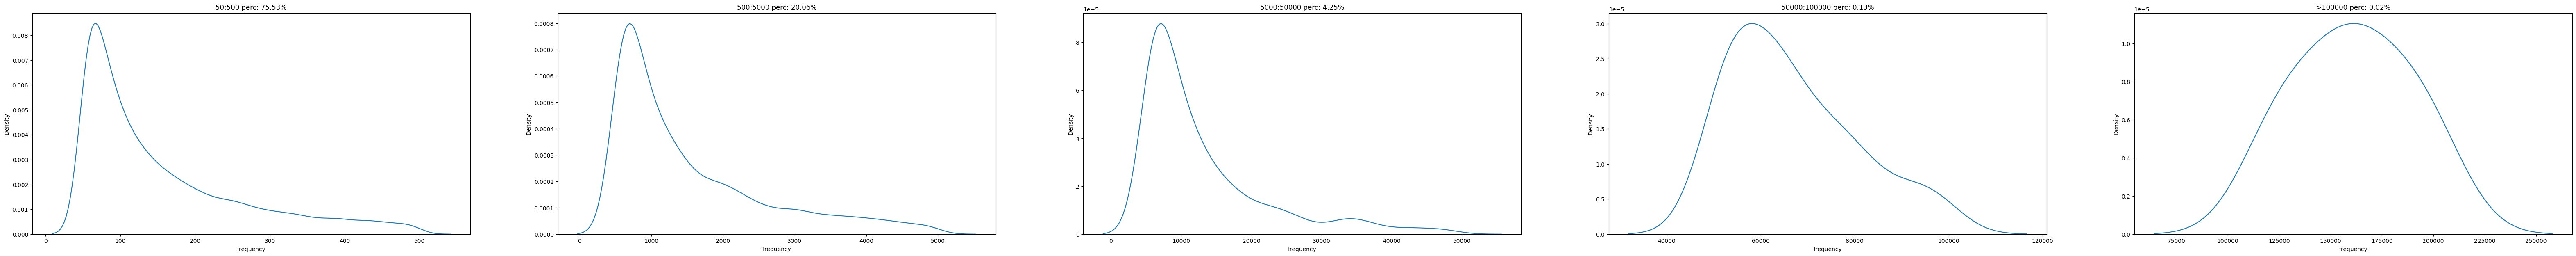

In [64]:
# Raggruppamento delle evidenze per cluster di frequenze
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(ncols=5, figsize=(80,7), gridspec_kw={'width_ratios': [2500,2500,2500,2500,2500]})
total = 42038
dataframe_frequency_500 = dataframe[(dataframe["frequency"]<=500)]
dataframe_frequency_500_5000 = dataframe[((dataframe["frequency"]>500) &(dataframe["frequency"]<=5000))]
dataframe_frequency_5000_50000 = dataframe[((dataframe["frequency"]>5000) &(dataframe["frequency"]<=50000))]
dataframe_frequency_50000_100000 = dataframe[((dataframe["frequency"]>50000) &(dataframe["frequency"]<=100000))]
dataframe_frequency_100000 = dataframe[(dataframe["frequency"]>100000)]

sb.kdeplot(dataframe_frequency_500['frequency'], ax=axs[0])
sb.kdeplot(dataframe_frequency_500_5000['frequency'], ax=axs[1])
sb.kdeplot(dataframe_frequency_5000_50000['frequency'], ax=axs[2])
sb.kdeplot(dataframe_frequency_50000_100000['frequency'], ax=axs[3])
sb.kdeplot(dataframe_frequency_100000['frequency'], ax=axs[4])
axs[0].title.set_text('50:500 perc: ' + str( round((dataframe_frequency_500.shape[0]/total)*100,2) ) + '%')
axs[1].title.set_text('500:5000 perc: ' + str( round((dataframe_frequency_500_5000.shape[0]/total)*100,2) ) + '%')
axs[2].title.set_text('5000:50000 perc: ' + str( round((dataframe_frequency_5000_50000.shape[0]/total)*100,2) ) + '%')
axs[3].title.set_text('50000:100000 perc: ' + str( round((dataframe_frequency_50000_100000.shape[0]/total)*100,2) ) + '%')
axs[4].title.set_text('>100000 perc: ' + str(round((dataframe_frequency_100000.shape[0]/total)*100,2) ) + '%')
plt.show()
# abbiamo suddiviso in 5 macro-classi
# riguardo alla distribuzione delle frequenze di ciascuna macroclasse si evince che la maggior parte delle evidenze, il 75%, 
# si concentra intorno a valori compresi tra 50 e 500, ora procederemo ad analizzare questa superclasse in modo più approfondito.

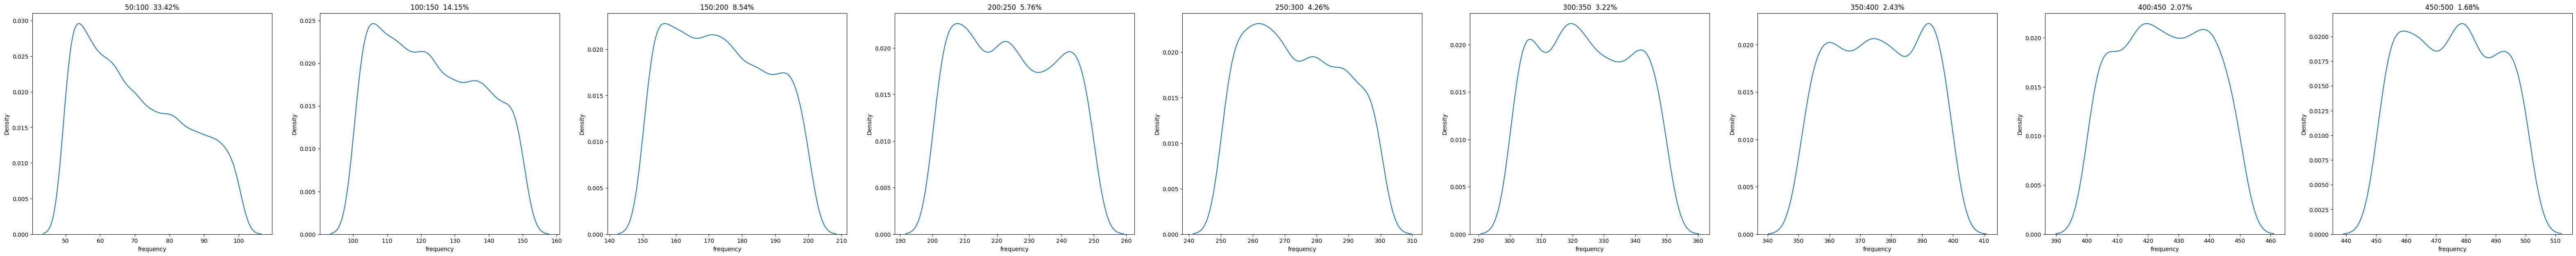

In [65]:
# analisi della class 50-500
fig, axs = plt.subplots(ncols=9, figsize=(80,7), gridspec_kw={'width_ratios': [2500,2500,2500,2500,2500,2500,2500,2500, 2500]})
total = 42038

dataframe_frequency_1_small = dataframe[(dataframe["frequency"]<= 100)]
dataframe_frequency_2_small = dataframe[((dataframe["frequency"]>100) &(dataframe["frequency"]<=150))]
dataframe_frequency_3_small = dataframe[((dataframe["frequency"]>150) &(dataframe["frequency"]<=200))]
dataframe_frequency_4_small = dataframe[((dataframe["frequency"]>200) &(dataframe["frequency"]<=250))]
dataframe_frequency_5_small = dataframe[((dataframe["frequency"]>250) &(dataframe["frequency"]<=300))]
dataframe_frequency_6_small = dataframe[((dataframe["frequency"]>300) &(dataframe["frequency"]<=350))]
dataframe_frequency_7_small = dataframe[((dataframe["frequency"]>350) &(dataframe["frequency"]<=400))]
dataframe_frequency_8_small = dataframe[((dataframe["frequency"]>400) &(dataframe["frequency"]<=450))]
dataframe_frequency_9_small = dataframe[((dataframe["frequency"]>450) &(dataframe["frequency"]<=500))]

sb.kdeplot(dataframe_frequency_1_small["frequency"], ax=axs[0])
sb.kdeplot(dataframe_frequency_2_small["frequency"], ax=axs[1])
sb.kdeplot(dataframe_frequency_3_small["frequency"], ax=axs[2])
sb.kdeplot(dataframe_frequency_4_small["frequency"], ax=axs[3])
sb.kdeplot(dataframe_frequency_5_small["frequency"], ax=axs[4])
sb.kdeplot(dataframe_frequency_6_small["frequency"], ax=axs[5])
sb.kdeplot(dataframe_frequency_7_small["frequency"], ax=axs[6])
sb.kdeplot(dataframe_frequency_8_small["frequency"], ax=axs[7])
sb.kdeplot(dataframe_frequency_9_small["frequency"], ax=axs[8])
axs[0].title.set_text('50:100  ' + str( round((dataframe_frequency_1_small.shape[0]/total)*100,2) ) + '%')
axs[1].title.set_text('100:150  ' + str( round((dataframe_frequency_2_small.shape[0]/total)*100,2) ) + '%')
axs[2].title.set_text('150:200  ' + str( round((dataframe_frequency_3_small.shape[0]/total)*100,2) ) + '%')
axs[3].title.set_text('200:250  ' + str( round((dataframe_frequency_4_small.shape[0]/total)*100,2) ) + '%')
axs[4].title.set_text('250:300  ' + str(round((dataframe_frequency_5_small.shape[0]/total)*100,2) ) + '%')
axs[5].title.set_text('300:350  ' + str( round((dataframe_frequency_6_small.shape[0]/total)*100,2) ) + '%')
axs[6].title.set_text('350:400  ' + str( round((dataframe_frequency_7_small.shape[0]/total)*100,2) ) + '%')
axs[7].title.set_text('400:450  ' + str( round((dataframe_frequency_8_small.shape[0]/total)*100,2) ) + '%')
axs[8].title.set_text('450:500  ' + str( round((dataframe_frequency_9_small.shape[0]/total)*100,2) ) + '%')
plt.show()

# da queste ulteriori subclass si può notare che più del 65% delle evidenze ha una frequenza compresa tra 50-300

In [66]:
float_range_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

data = []
for i in float_range_list:
    data.append([dataframe_frequency_1_small["frequency"].quantile(i), dataframe_frequency_1_small["volumes"].quantile(i)])
dataframe_1_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_1_final = dataframe_1_final.drop(dataframe_1_final['median_frequency'].idxmax())
dataframe_1_final = dataframe_1_final.drop(dataframe_1_final['median_frequency'].idxmax())
dataframe_1_final = dataframe_1_final.drop(dataframe_1_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_frequency_2_small["frequency"].quantile(i), dataframe_frequency_2_small["volumes"].quantile(i)])
dataframe_2_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_2_final = dataframe_2_final.drop(dataframe_2_final['median_frequency'].idxmax())
dataframe_2_final = dataframe_2_final.drop(dataframe_2_final['median_frequency'].idxmax())
dataframe_2_final = dataframe_2_final.drop(dataframe_2_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_frequency_3_small["frequency"].quantile(i), dataframe_frequency_3_small["volumes"].quantile(i)])
dataframe_3_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_3_final = dataframe_3_final.drop(dataframe_3_final['median_frequency'].idxmax())
dataframe_3_final = dataframe_3_final.drop(dataframe_3_final['median_frequency'].idxmax())
dataframe_3_final = dataframe_3_final.drop(dataframe_3_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_frequency_4_small["frequency"].quantile(i), dataframe_frequency_4_small["volumes"].quantile(i)])
dataframe_4_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_4_final = dataframe_4_final.drop(dataframe_4_final['median_frequency'].idxmax())
dataframe_4_final = dataframe_4_final.drop(dataframe_4_final['median_frequency'].idxmax())
dataframe_4_final = dataframe_4_final.drop(dataframe_4_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_frequency_5_small["frequency"].quantile(i), dataframe_frequency_5_small["volumes"].quantile(i)])
dataframe_5_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_5_final = dataframe_5_final.drop(dataframe_5_final['median_frequency'].idxmax())
dataframe_5_final = dataframe_5_final.drop(dataframe_5_final['median_frequency'].idxmax())
dataframe_5_final = dataframe_5_final.drop(dataframe_5_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_frequency_6_small["frequency"].quantile(i), dataframe_frequency_6_small["volumes"].quantile(i)])
dataframe_6_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_6_final = dataframe_6_final.drop(dataframe_6_final['median_frequency'].idxmax())
dataframe_6_final = dataframe_6_final.drop(dataframe_6_final['median_frequency'].idxmax())
dataframe_6_final = dataframe_6_final.drop(dataframe_6_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_frequency_7_small["frequency"].quantile(i), dataframe_frequency_7_small["volumes"].quantile(i)])
dataframe_7_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_7_final = dataframe_7_final.drop(dataframe_7_final['median_frequency'].idxmax())
dataframe_7_final = dataframe_7_final.drop(dataframe_7_final['median_frequency'].idxmax())
dataframe_7_final = dataframe_7_final.drop(dataframe_7_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_frequency_8_small["frequency"].quantile(i), dataframe_frequency_8_small["volumes"].quantile(i)])
dataframe_8_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_8_final = dataframe_8_final.drop(dataframe_8_final['median_frequency'].idxmax())
dataframe_8_final = dataframe_8_final.drop(dataframe_8_final['median_frequency'].idxmax())
dataframe_8_final = dataframe_8_final.drop(dataframe_8_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_frequency_9_small["frequency"].quantile(i), dataframe_frequency_9_small["volumes"].quantile(i)])
dataframe_9_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_9_final = dataframe_9_final.drop(dataframe_9_final['median_frequency'].idxmax())
dataframe_9_final = dataframe_9_final.drop(dataframe_9_final['median_frequency'].idxmax())
dataframe_9_final = dataframe_9_final.drop(dataframe_9_final['median_frequency'].idxmax())

# per vedere se cè una correlazione tra il volume e l'aumento della frequenza
# ho considerato il quantile delle frequenze e del volume con step di 0.05 e si vede che per le sottoclassi più numerose la correlazione sussiste.
# adesso provvederemo a calcolare il grafico dove mostriamo la regressione lineare.

In [67]:
dataframe_4_final.head(20)

,median_frequency,median_volumes
0,203.0,6.404555e-07
1,205.0,1.888968e-06
2,207.0,4.425900e-06
3,209.0,9.177929e-06
4,211.0,1.565653e-05
5,213.0,3.005733e-05
6,216.0,4.920480e-05
7,219.0,8.020322e-05
8,224.0,1.900408e-04
9,226.0,2.980652e-04


/home/fmollica/.local/lib/python3.8/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


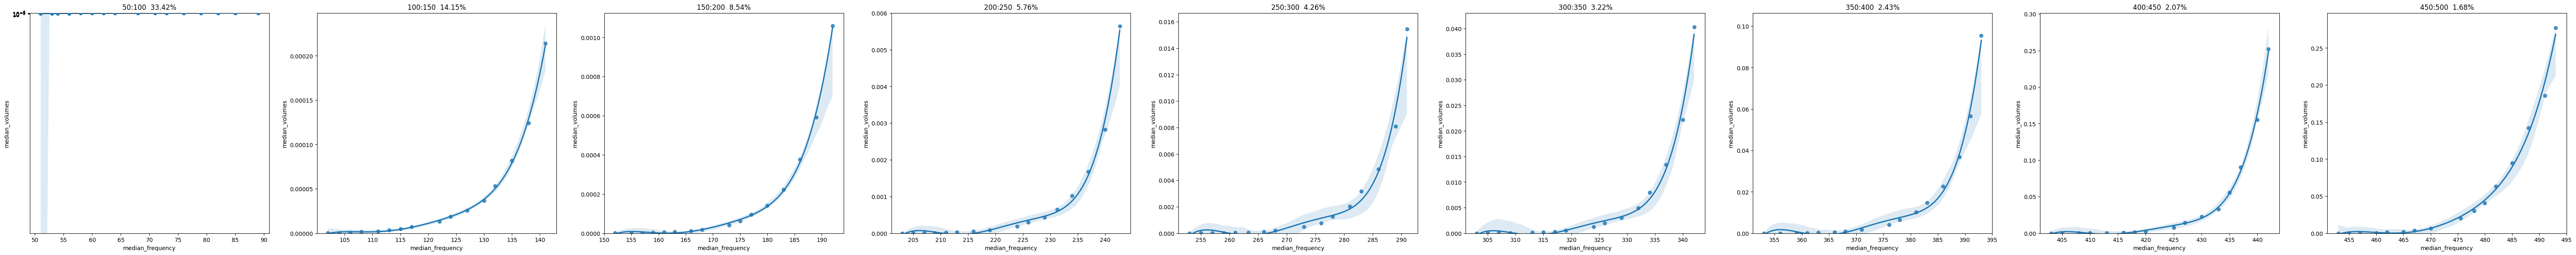

In [68]:
fig, axs = plt.subplots(ncols=9, figsize=(80,7), gridspec_kw={'width_ratios': [2500,2500,2500,2500,2500,2500,2500,2500, 2500]})
total = 42038

g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_1_final, ax=axs[0], order=5, scatter_kws={"zorder":10, "alpha":1})
g.set(ylim=(0, None))
g.set(yscale='log')
g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_2_final, ax=axs[1], order=5)
g.set(ylim=(0, None))
g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_3_final, ax=axs[2], order=5)
g.set(ylim=(0, None))
g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_4_final, ax=axs[3], order=5)
g.set(ylim=(0, None))
g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_5_final, ax=axs[4], order=5)
g.set(ylim=(0, None))
g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_6_final, ax=axs[5], order=5)
g.set(ylim=(0, None))
g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_7_final, ax=axs[6], order=5)
g.set(ylim=(0, None))
g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_8_final, ax=axs[7], order=5)
g.set(ylim=(0, None))
g = sb.regplot(x="median_frequency", y="median_volumes", data=dataframe_9_final, ax=axs[8], order=5)
g.set(ylim=(0, None))
axs[0].title.set_text('50:100  ' +  str( round((dataframe_frequency_1_small.shape[0]/total)*100,2)) + '%')
axs[1].title.set_text('100:150  ' + str( round((dataframe_frequency_2_small.shape[0]/total)*100,2)) + '%')
axs[2].title.set_text('150:200  ' + str( round((dataframe_frequency_3_small.shape[0]/total)*100,2)) + '%')
axs[3].title.set_text('200:250  ' + str( round((dataframe_frequency_4_small.shape[0]/total)*100,2)) + '%')
axs[4].title.set_text('250:300  ' + str( round((dataframe_frequency_5_small.shape[0]/total)*100,2)) + '%')
axs[5].title.set_text('300:350  ' + str( round((dataframe_frequency_6_small.shape[0]/total)*100,2)) + '%')
axs[6].title.set_text('350:400  ' + str( round((dataframe_frequency_7_small.shape[0]/total)*100,2)) + '%')
axs[7].title.set_text('400:450  ' + str( round((dataframe_frequency_8_small.shape[0]/total)*100,2)) + '%') 
axs[8].title.set_text('450:500  ' + str( round((dataframe_frequency_9_small.shape[0]/total)*100,2)) + '%')
plt.show()

<ipython-input-61-b88dc5b9ecca>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dataframe_frequency_2_small.append(dataframe_frequency_3_small)
<ipython-input-61-b88dc5b9ecca>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe_frequency_4_small)


    median_frequency  median_volumes
0              104.0    2.574666e-07
1              108.0    6.653428e-07
2              113.0    1.246452e-06
3              117.0    2.178623e-06
4              122.0    3.618823e-06
5              127.0    5.564470e-06
6              133.0    8.782095e-06
7              138.0    1.308765e-05
8              151.0    2.781835e-05
9              158.0    4.166827e-05
10             165.0    6.292802e-05
11             173.0    9.612788e-05
12             182.0    1.464156e-04
13             191.0    2.503090e-04
14             201.0    4.348311e-04
15             212.0    8.002975e-04
16             224.0    1.739947e-03
17             238.0    5.960266e-03


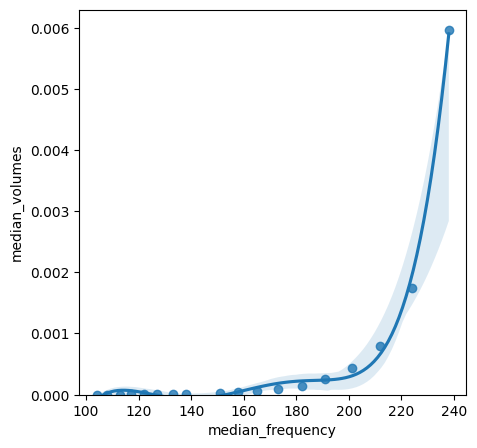

In [61]:
df = dataframe_frequency_2_small.append(dataframe_frequency_3_small)
df = df.append(dataframe_frequency_4_small)
float_range_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
data = []
for i in float_range_list:
    data.append([df["frequency"].quantile(i), df["volumes"].quantile(i)])
df_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
df_final = df_final.drop(df_final['median_frequency'].idxmax())
print(df_final.head(20))
fig, axs = plt.subplots(ncols=1, figsize=(5,5), gridspec_kw={'width_ratios': [2500]})
g = sb.regplot(x="median_frequency", y="median_volumes", data=df_final, order=5)
g.set(ylim=(0, None))
plt.show()

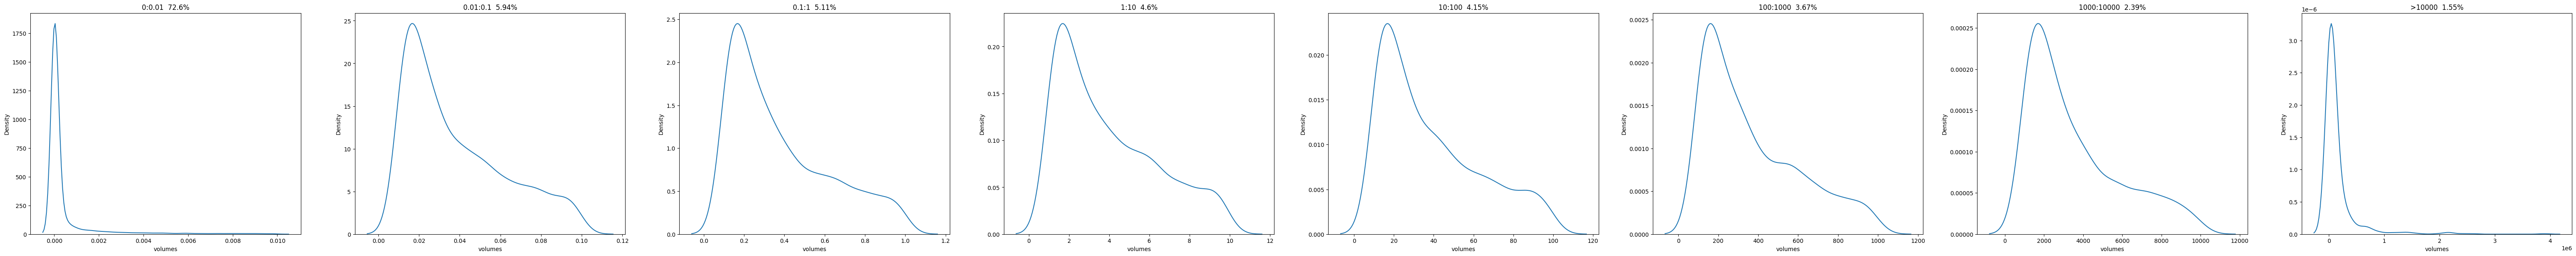

In [44]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(ncols=8, figsize=(80,7), gridspec_kw={'width_ratios': [2500,2500,2500,2500,2500,2500,2500,2500]})
total = 42038
dataframe_volume_0_001 = dataframe[(dataframe["volumes"]<= 0.01)]
dataframe_volume_001_01 = dataframe[((dataframe["volumes"]>0.01) &(dataframe["volumes"]<=0.1))]
dataframe_volume_01_1 = dataframe[((dataframe["volumes"]>0.1) &(dataframe["volumes"]<=1))]
dataframe_volume_1_10 = dataframe[((dataframe["volumes"]>1) &(dataframe["volumes"]<=10))]
dataframe_volume_10_100 = dataframe[((dataframe["volumes"]>10) &(dataframe["volumes"]<=100))]
dataframe_volume_100_1000 = dataframe[((dataframe["volumes"]>100) &(dataframe["volumes"]<=1000))]
dataframe_volume_1000_10000 = dataframe[((dataframe["volumes"]>1000) &(dataframe["volumes"]<=10000))]
dataframe_volume_10000 = dataframe[(dataframe["volumes"]>10000)]

sb.kdeplot(dataframe_volume_0_001['volumes'], ax=axs[0])
sb.kdeplot(dataframe_volume_001_01['volumes'], ax=axs[1])
sb.kdeplot(dataframe_volume_01_1['volumes'], ax=axs[2])
sb.kdeplot(dataframe_volume_1_10['volumes'], ax=axs[3])
sb.kdeplot(dataframe_volume_10_100['volumes'], ax=axs[4])
sb.kdeplot(dataframe_volume_100_1000['volumes'], ax=axs[5])
sb.kdeplot(dataframe_volume_1000_10000['volumes'], ax=axs[6])
sb.kdeplot(dataframe_volume_10000['volumes'], ax=axs[7])
axs[0].title.set_text('0:0.01  ' + str( round((dataframe_volume_0_001.shape[0]/total)*100,2) ) + '%')
axs[1].title.set_text('0.01:0.1  ' + str( round((dataframe_volume_001_01.shape[0]/total)*100,2) ) + '%')
axs[2].title.set_text('0.1:1  ' + str( round((dataframe_volume_01_1.shape[0]/total)*100,2) ) + '%')
axs[3].title.set_text('1:10  ' + str( round((dataframe_volume_1_10.shape[0]/total)*100,2) ) + '%')
axs[4].title.set_text('10:100  ' + str(round((dataframe_volume_10_100.shape[0]/total)*100,2) ) + '%')
axs[5].title.set_text('100:1000  ' + str( round((dataframe_volume_100_1000.shape[0]/total)*100,2) ) + '%')
axs[6].title.set_text('1000:10000  ' + str( round((dataframe_volume_1000_10000.shape[0]/total)*100,2) ) + '%')
axs[7].title.set_text('>10000  ' + str( round((dataframe_volume_10000.shape[0]/total)*100,2) ) + '%')
plt.show()
# passiamo alla controprova, e studiamo l'anadamento delle evidenze secondo i volumi.
# riguardo alla distribuzione dei volumi si evince che la maggior parte si concentra intorno a valori estremamente prossimi allo zero, ora procederemo ad analizzare la prima classe in modo più approfondito.

/home/fmollica/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


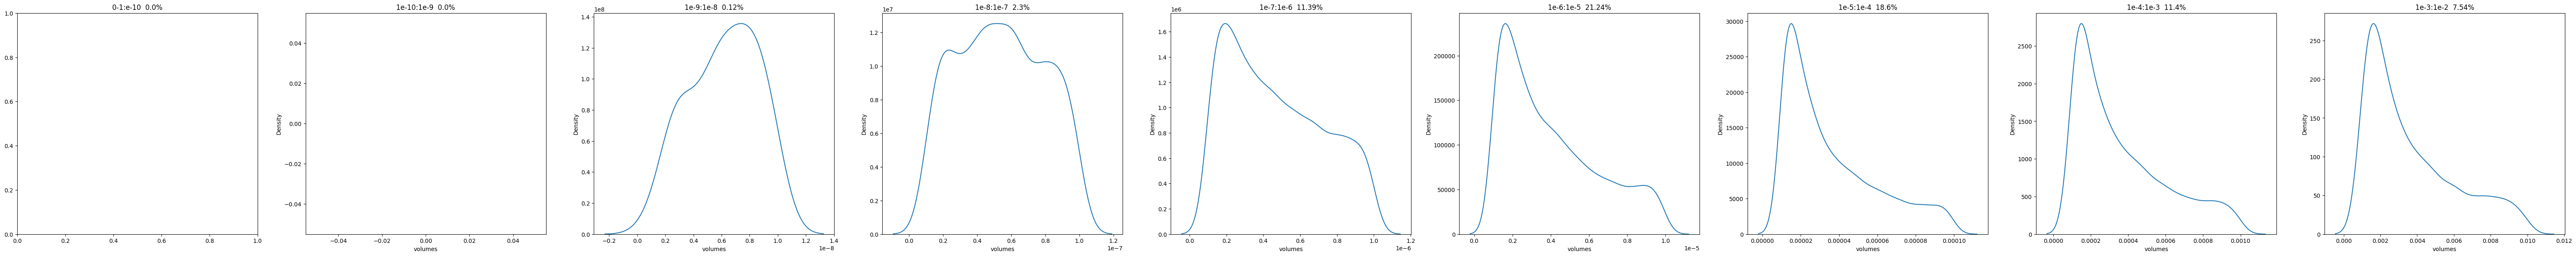

In [45]:
# analisi della class 0-0.01
fig, axs = plt.subplots(ncols=9, figsize=(80,7), gridspec_kw={'width_ratios': [2500,2500,2500,2500,2500,2500,2500,2500, 2500]})
total = 42038

dataframe_volume_1_small = dataframe[(dataframe["volumes"]<= 1e-10)]
dataframe_volume_2_small = dataframe[((dataframe["volumes"]>1e-10) & (dataframe["volumes"]<=1e-9))]
dataframe_volume_3_small = dataframe[((dataframe["volumes"]>1e-9) &(dataframe["volumes"]<=1e-8))]
dataframe_volume_4_small = dataframe[((dataframe["volumes"]>1e-8) &(dataframe["volumes"]<=1e-7))]
dataframe_volume_5_small = dataframe[((dataframe["volumes"]>1e-7) &(dataframe["volumes"]<=1e-6))]
dataframe_volume_6_small = dataframe[((dataframe["volumes"]>1e-6) &(dataframe["volumes"]<=1e-5))]
dataframe_volume_7_small = dataframe[((dataframe["volumes"]>1e-5) &(dataframe["volumes"]<=1e-4))]
dataframe_volume_8_small = dataframe[((dataframe["volumes"]>1e-4) &(dataframe["volumes"]<=1e-3))]
dataframe_volume_9_small = dataframe[((dataframe["volumes"]>1e-3) &(dataframe["volumes"]<=1e-2))]

sb.kdeplot(dataframe_volume_1_small['volumes'], ax=axs[0])
sb.kdeplot(dataframe_volume_2_small['volumes'], ax=axs[1])
sb.kdeplot(dataframe_volume_3_small['volumes'], ax=axs[2])
sb.kdeplot(dataframe_volume_4_small['volumes'], ax=axs[3])
sb.kdeplot(dataframe_volume_5_small['volumes'], ax=axs[4])
sb.kdeplot(dataframe_volume_6_small['volumes'], ax=axs[5])
sb.kdeplot(dataframe_volume_7_small['volumes'], ax=axs[6])
sb.kdeplot(dataframe_volume_8_small['volumes'], ax=axs[7])
sb.kdeplot(dataframe_volume_9_small['volumes'], ax=axs[8])
axs[0].title.set_text('0:1e-10  ' + str( round((dataframe_volume_1_small.shape[0]/total)*100,2) ) + '%')
axs[1].title.set_text('1e-10:1e-9  ' + str( round((dataframe_volume_2_small.shape[0]/total)*100,2) ) + '%')
axs[2].title.set_text('1e-9:1e-8  ' + str( round((dataframe_volume_3_small.shape[0]/total)*100,2) ) + '%')
axs[3].title.set_text('1e-8:1e-7  ' + str( round((dataframe_volume_4_small.shape[0]/total)*100,2) ) + '%')
axs[4].title.set_text('1e-7:1e-6  ' + str(round((dataframe_volume_5_small.shape[0]/total)*100,2) ) + '%')
axs[5].title.set_text('1e-6:1e-5  ' + str( round((dataframe_volume_6_small.shape[0]/total)*100,2) ) + '%')
axs[6].title.set_text('1e-5:1e-4  ' + str( round((dataframe_volume_7_small.shape[0]/total)*100,2) ) + '%')
axs[7].title.set_text('1e-4:1e-3  ' + str( round((dataframe_volume_8_small.shape[0]/total)*100,2) ) + '%')
axs[8].title.set_text('1e-3:1e-2  ' + str( round((dataframe_volume_9_small.shape[0]/total)*100,2) ) + '%')
plt.show()

# da queste ulteriori subclass si può notare che più del 60% dei volumi assume un valore tra e-7 e e-3


In [46]:
float_range_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

data = []
for i in float_range_list:
    data.append([dataframe_volume_1_small["frequency"].quantile(i), dataframe_volume_1_small["volumes"].quantile(i)])
dataframe_1_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
#dataframe_1_final = dataframe_1_final.drop(dataframe_1_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_volume_2_small["frequency"].quantile(i), dataframe_volume_2_small["volumes"].quantile(i)])
dataframe_2_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_2_final = dataframe_2_final.drop(dataframe_2_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_volume_3_small["frequency"].quantile(i), dataframe_volume_3_small["volumes"].quantile(i)])
dataframe_3_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_3_final = dataframe_3_final.drop(dataframe_3_final['median_frequency'].idxmax())
dataframe_3_final = dataframe_3_final.drop(dataframe_3_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_volume_4_small["frequency"].quantile(i), dataframe_volume_4_small["volumes"].quantile(i)])
dataframe_4_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_4_final = dataframe_4_final.drop(dataframe_4_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_volume_5_small["frequency"].quantile(i), dataframe_volume_5_small["volumes"].quantile(i)])
dataframe_5_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_5_final = dataframe_5_final.drop(dataframe_5_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_volume_6_small["frequency"].quantile(i), dataframe_volume_6_small["volumes"].quantile(i)])
dataframe_6_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_6_final = dataframe_6_final.drop(dataframe_6_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_volume_7_small["frequency"].quantile(i), dataframe_volume_7_small["volumes"].quantile(i)])
dataframe_7_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_7_final = dataframe_7_final.drop(dataframe_7_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_volume_8_small["frequency"].quantile(i), dataframe_volume_8_small["volumes"].quantile(i)])
dataframe_8_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_8_final = dataframe_8_final.drop(dataframe_8_final['median_frequency'].idxmax())

data = []
for i in float_range_list:
    data.append([dataframe_volume_9_small["frequency"].quantile(i), dataframe_volume_9_small["volumes"].quantile(i)])
dataframe_9_final = pd.DataFrame(data, columns = ['median_frequency', 'median_volumes'])
dataframe_9_final = dataframe_9_final.drop(dataframe_9_final['median_frequency'].idxmax())

# per vedere se cè una correlazione tra la frequenza e l'aumento del volume
# ho considerato il valore mediano delle frequenze e del volume e si vede che per le sottoclassi più numerose la correlazione sussiste.
# adesso provvederemo a calcolare il grafico dove mostriamo la regressione lineare.


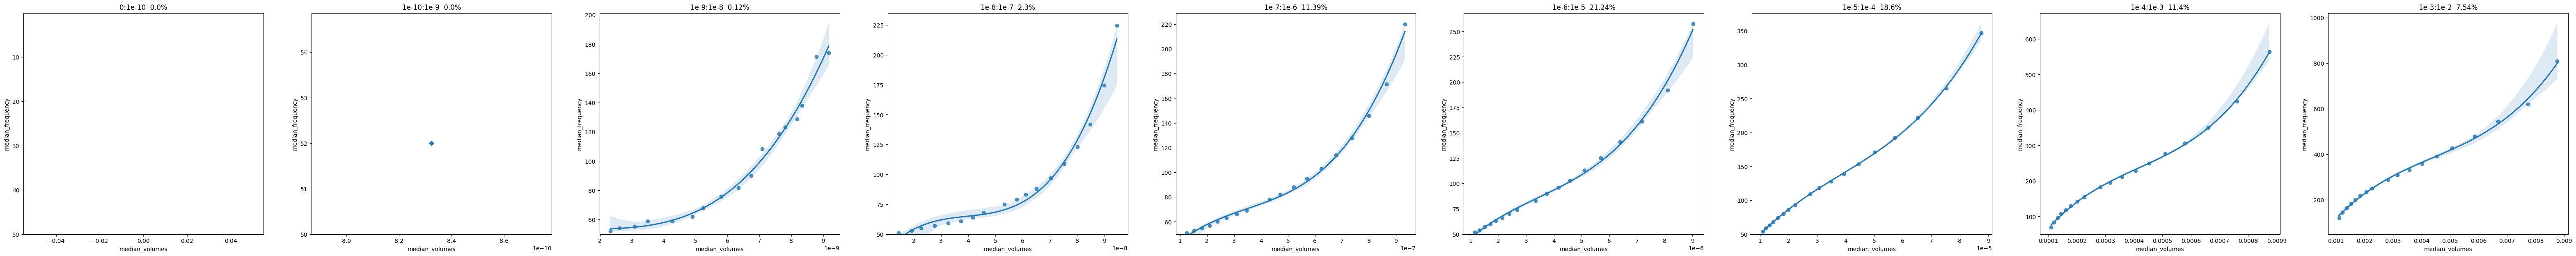

In [48]:
fig, axs = plt.subplots(ncols=9, figsize=(80,7), gridspec_kw={'width_ratios': [2500,2500,2500,2500,2500,2500,2500,2500, 2500]})
total = 42038

g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_1_final, ax=axs[0], order=1)
g.set(ylim=(50, None))
g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_2_final, ax=axs[1], order=1)
g.set(ylim=(50, None))
g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_3_final, ax=axs[2], order=3)
g.set(ylim=(50, None))
g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_4_final, ax=axs[3], order=3)
g.set(ylim=(50, None))
g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_5_final, ax=axs[4], order=3)
g.set(ylim=(50, None))
g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_6_final, ax=axs[5], order=3)
g.set(ylim=(50, None))
g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_7_final, ax=axs[6], order=3)
g.set(ylim=(50, None))
g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_8_final, ax=axs[7], order=3)
g.set(ylim=(50, None))
g = sb.regplot(x="median_volumes", y="median_frequency", data=dataframe_9_final, ax=axs[8], order=3)
g.set(ylim=(50, None))

axs[0].title.set_text('0:1e-10  ' + str( round((dataframe_volume_1_small.shape[0]/total)*100,2) ) + '%')
axs[1].title.set_text('1e-10:1e-9  ' + str( round((dataframe_volume_2_small.shape[0]/total)*100,2) ) + '%')
axs[2].title.set_text('1e-9:1e-8  ' + str( round((dataframe_volume_3_small.shape[0]/total)*100,2) ) + '%')
axs[3].title.set_text('1e-8:1e-7  ' + str( round((dataframe_volume_4_small.shape[0]/total)*100,2) ) + '%')
axs[4].title.set_text('1e-7:1e-6  ' + str(round((dataframe_volume_5_small.shape[0]/total)*100,2) ) + '%')
axs[5].title.set_text('1e-6:1e-5  ' + str( round((dataframe_volume_6_small.shape[0]/total)*100,2) ) + '%')
axs[6].title.set_text('1e-5:1e-4  ' + str( round((dataframe_volume_7_small.shape[0]/total)*100,2) ) + '%')
axs[7].title.set_text('1e-4:1e-3  ' + str( round((dataframe_volume_8_small.shape[0]/total)*100,2) ) + '%')
axs[8].title.set_text('1e-3:1e-2  ' + str( round((dataframe_volume_9_small.shape[0]/total)*100,2) ) + '%')
plt.show()

In [ ]:
dataframe_volume_3_small.head(30)
df = dataframe_volume_1_small.append(dataframe_volume_2_small)
df = df.append(dataframe_volume_3_small)
df = df.append(dataframe_volume_4_small)
df = df.append(dataframe_volume_5_small)
df = df.append(dataframe_volume_6_small)
df = df.append(dataframe_volume_7_small)
df = df.append(dataframe_volume_8_small)
df = df.append(dataframe_volume_9_small)

df.head()

In [5]:

new_col = dataframe_volume_frequency_quantile["frequency"].value_counts()  # can be a list, a Series, an array or a scalar
df = pd.DataFrame(new_col)
df.reset_index(level=0, inplace=True)
df.rename(columns={"index":"frequency", "frequency":"number"} ,inplace=True)

grouped_df = dataframe_volume_frequency_quantile.groupby("frequency")

min_quantile = grouped_df.quantile(0.025)
max_quantile = grouped_df.quantile(0.975)

medians = grouped_df.median()
means = grouped_df.mean()

df = df.assign(max_quantile=min_quantile["volumes"].values)
df = df.assign(min_quantile=max_quantile["volumes"].values)
df = df.assign(median=medians["volumes"].values)
df = df.assign(mean=means["volumes"].values)
df

,frequency,number,max_quantile,min_quantile,median,mean
0,50,478,3.960356e-08,7.353371e-05,2.054838e-06,1.014611e-05
1,53,457,4.704679e-08,9.763993e-05,2.094213e-06,1.275410e-05
2,51,442,4.513009e-08,8.984710e-05,2.464568e-06,1.219852e-05
3,52,435,4.164457e-08,8.130644e-05,2.354934e-06,1.188386e-05
4,55,432,5.569381e-08,1.039076e-04,2.475535e-06,1.240588e-05
...,...,...,...,...,...,...
5006,5397,1,3.444175e+05,3.444175e+05,3.444175e+05,3.444175e+05
5007,3133,1,2.411586e+06,2.411586e+06,2.411586e+06,2.411586e+06
5008,26230,1,1.509402e+06,1.509402e+06,1.509402e+06,1.509402e+06
5009,12444,1,8.632256e+05,8.632256e+05,8.632256e+05,8.632256e+05
